In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. 导入数据集

In [11]:
path = "../Data/exercise_data/chipotle.tsv"

# tsv的数据用\t作为分隔符
df = pd.read_csv(path, sep='\t')

### 2.查看基本信息

In [12]:
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            4622 non-null   int64 
 1   quantity            4622 non-null   int64 
 2   item_name           4622 non-null   object
 3   choice_description  3376 non-null   object
 4   item_price          4622 non-null   object
dtypes: int64(2), object(3)
memory usage: 180.7+ KB


### 2.1 数据字段梳理

该样本数据集为Chipotle快餐厅数据，包含5列信息
+ `order_id`:订单编号
+ `quantity`:购买数量
+ `item_name`:商品名称
+ `choice_description`:选择描述，应是订单中的配料选择记录
+ `item_price`:商品价格

### 2.2 缺失数据确认

In [14]:
missing = df.isnull().sum() / len(df)
missing

order_id              0.00000
quantity              0.00000
item_name             0.00000
choice_description    0.26958
item_price            0.00000
dtype: float64

`choice_description`项有26.96%的数据缺失

## 3. 数据预处理

在查看基本信息的过程中，我们注意到`item_price`的类型为`object`，由于该字段为金额，所以我们将其转化为浮点数

In [18]:
df.item_price = df.item_price.str.replace('$', '').astype(float)
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39
1,1,1,Izze,[Clementine],3.39
2,1,1,Nantucket Nectar,[Apple],3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98


## 4.探索性分析

### 问题：

1. 一共有多少种商品出售
2. 销量最高的前5类商品
3. 销售额最高的前5类商品
4. 配料中需求量最大的5类商品
5. 平均每笔订单的金额是多少

### 4.1 一共有多少种商品出售？

In [102]:
len(df.item_name.unique())

50

一共有五十种商品出售


### 4.2 销量最高的前5类商品
销量等于商品的销售数量之和

In [37]:
df.groupby('item_name').count().order_id.sort_values(ascending=False).head()

item_name
Chicken Bowl           726
Chicken Burrito        553
Chips and Guacamole    479
Steak Burrito          368
Canned Soft Drink      301
Name: order_id, dtype: int64

In [38]:
sales_quantity = df.groupby('item_name').quantity.sum().sort_values(ascending=False)
sales_quantity.head(5)

item_name
Chicken Bowl           761
Chicken Burrito        591
Chips and Guacamole    506
Steak Burrito          386
Canned Soft Drink      351
Name: quantity, dtype: int64

比较两项输出结果，后者的数值都高于前者，如果只统计商品名称次数的话会产生遗漏

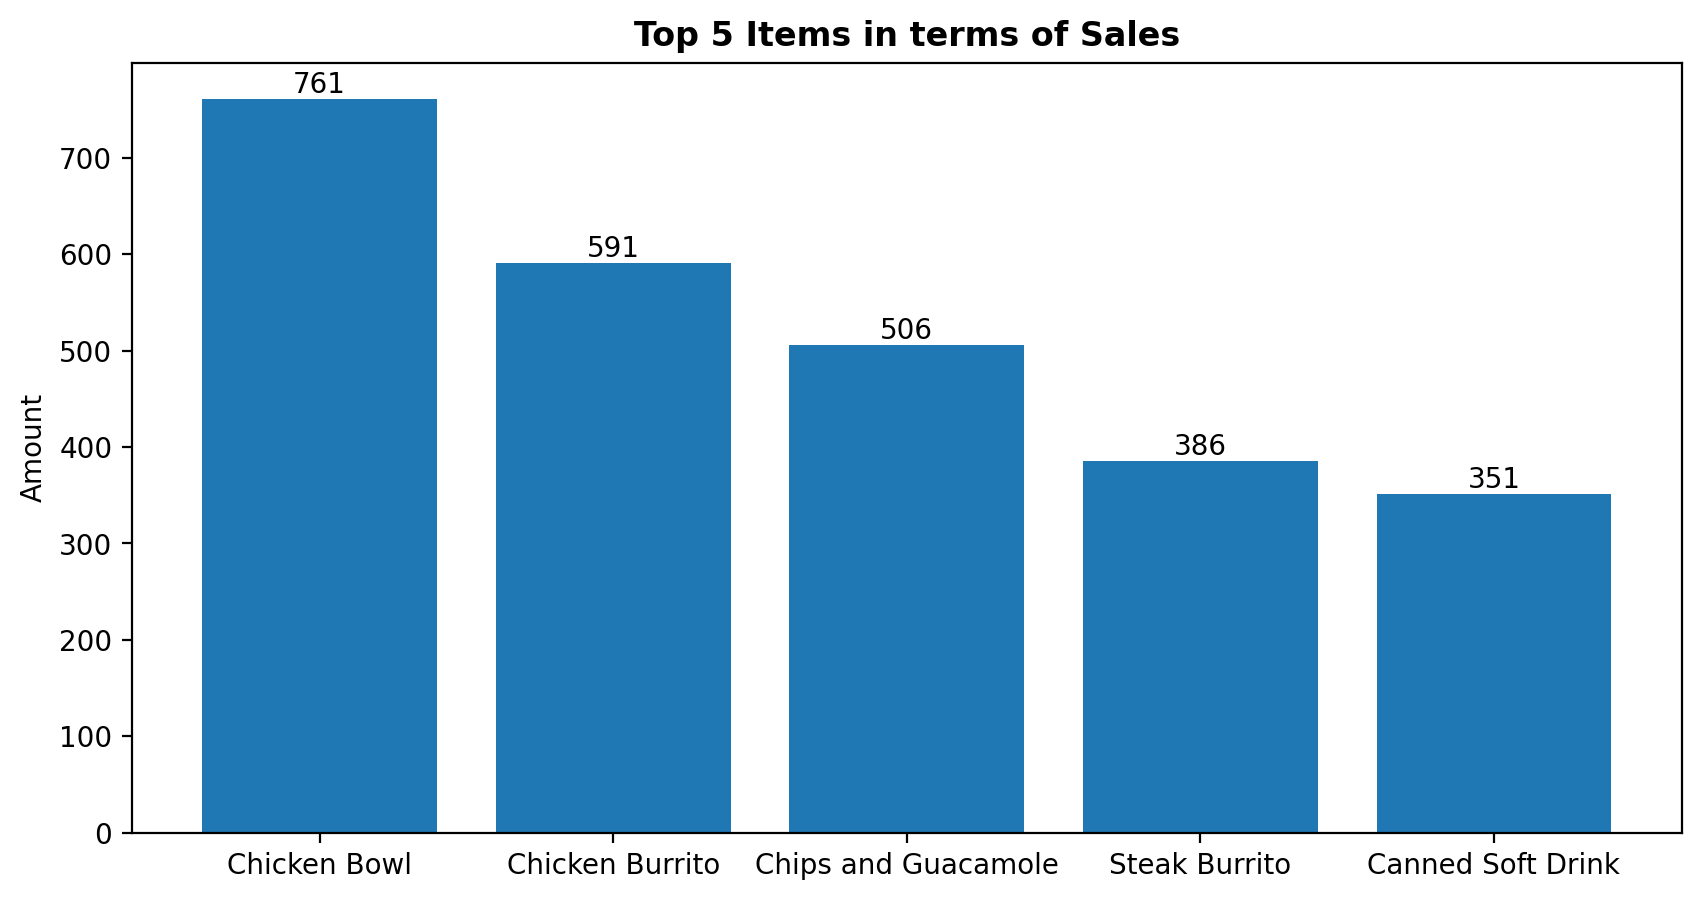

In [94]:
fig, ax = plt.subplots(figsize=(10,5), dpi=200)
bars = ax.bar(sales_quantity.head(5).index, sales_quantity.head(5))
ax.bar_label(bars)
plt.title('Top 5 Items in terms of Sales', fontweight='bold')
plt.ylabel("Amount")
plt.xticks(rotation=0)

plt.show();

In [61]:
#计算Chicken Bowl在总销量中的占比
f"{sales_quantity.loc['Chicken Bowl'] / sales_quantity.sum()*100:.2f}%"

'15.31%'

**结论**：Chicken Bowl是卖得最好的商品，占总体销售量的15.31%

### 4.3 销售额最高的前5类商品

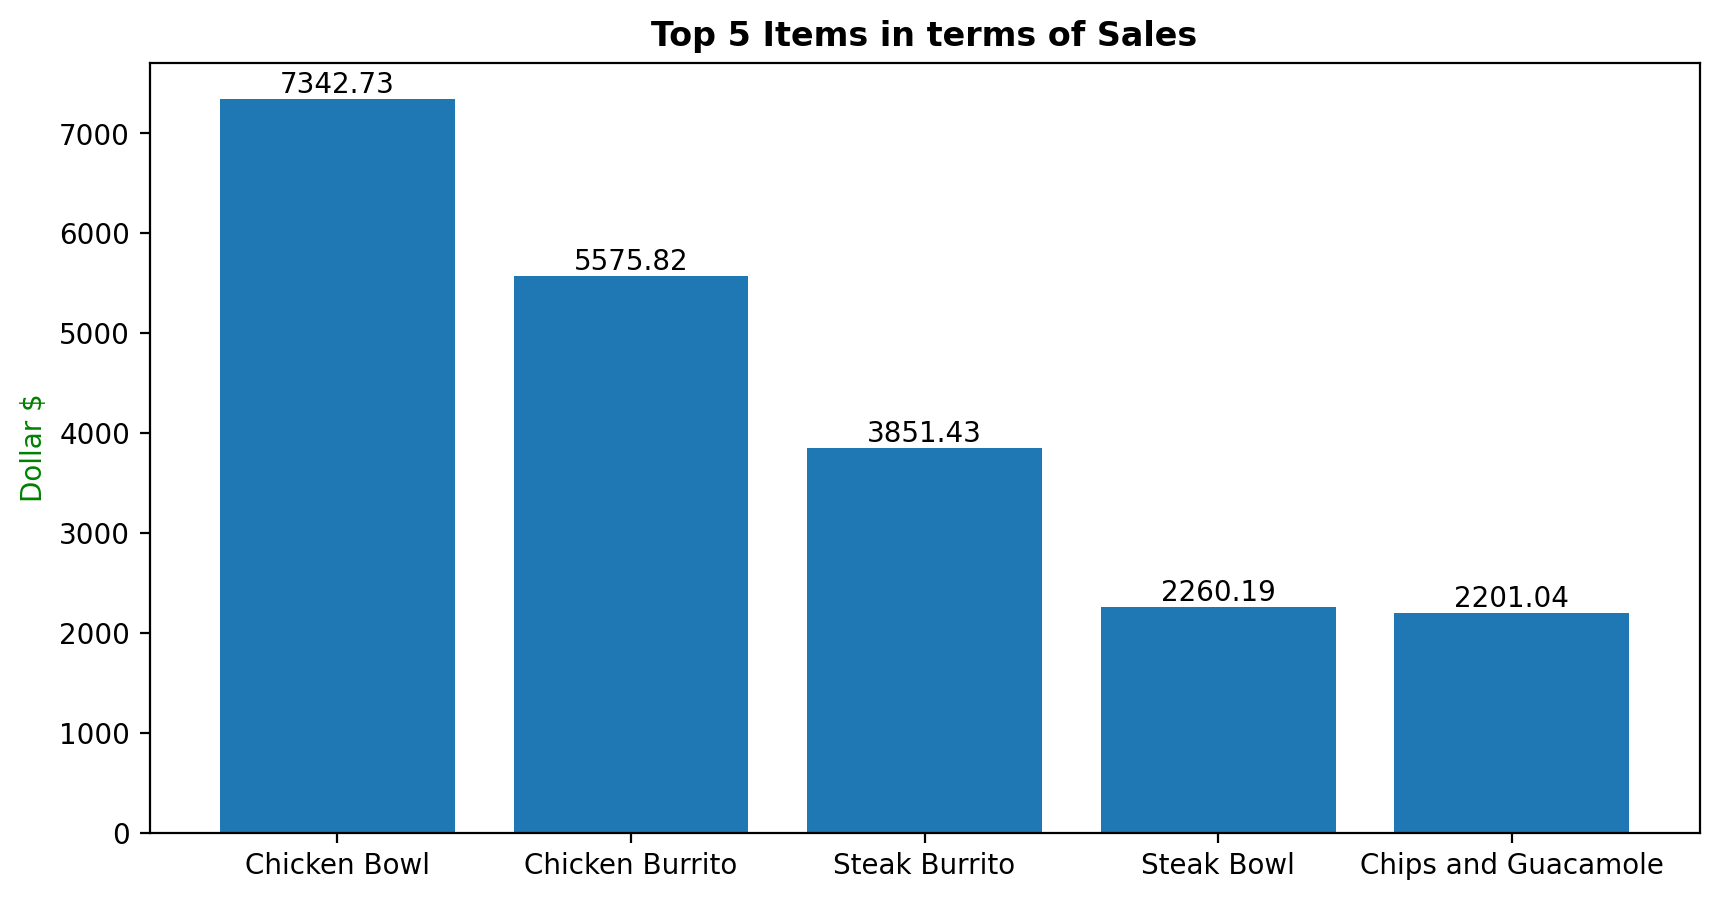

In [99]:
sales_income = df.groupby('item_name').item_price.sum().sort_values(ascending=False)

#绘出柱状图

fig, ax = plt.subplots(figsize=(10,5), dpi=200)
bars = ax.bar(sales_income.head(5).index, sales_income.head(5))
ax.bar_label(bars)
plt.title('Top 5 Items in terms of Sales', fontweight='bold')
plt.ylabel("Dollar $", color='g')
plt.xticks(rotation=0)

plt.show();

### 4.4 配料中的商品分析

由于每一项实例的备注包含了许多商品，我们需要对其进行规范化处理

In [135]:
import re
from collections import Counter

# 去除空白数据，并将该字段整合为列表
description = df.choice_description.dropna().tolist()

items = []
for entry in description:
    # 使用正则表达移除大括号，并用逗号分隔，去掉空格
    cleaned_items = re.sub(r'[\[\]]','',entry).split(',')
    stripped_items = [s.strip() for s in cleaned_items]
    items.extend(stripped_items)

# 使用Python自带函数Counter统计列表中各项的次数
item_counts = Counter(items)

description_items = pd.Series(item_counts).sort_values(ascending=False)

In [151]:
description_items

Rice                                    2389
Cheese                                  2281
Lettuce                                 1742
Sour Cream                              1711
Black Beans                             1342
Fresh Tomato Salsa                      1046
Guacamole                               1037
Fajita Vegetables                        722
Pinto Beans                              582
Roasted Chili Corn Salsa                 457
Fresh Tomato Salsa (Mild)                351
Tomatillo Red Chili Salsa                325
Fajita Veggies                           302
Roasted Chili Corn Salsa (Medium)        270
Tomatillo-Red Chili Salsa (Hot)          259
Tomatillo Green Chili Salsa              230
Diet Coke                                134
Tomatillo-Green Chili Salsa (Medium)     128
Coke                                     123
Sprite                                    77
Lemonade                                  33
Fresh Tomato (Mild)                       31
Coca Cola 

In [143]:
len(description_items)

46

备注中一共有46种商品出现

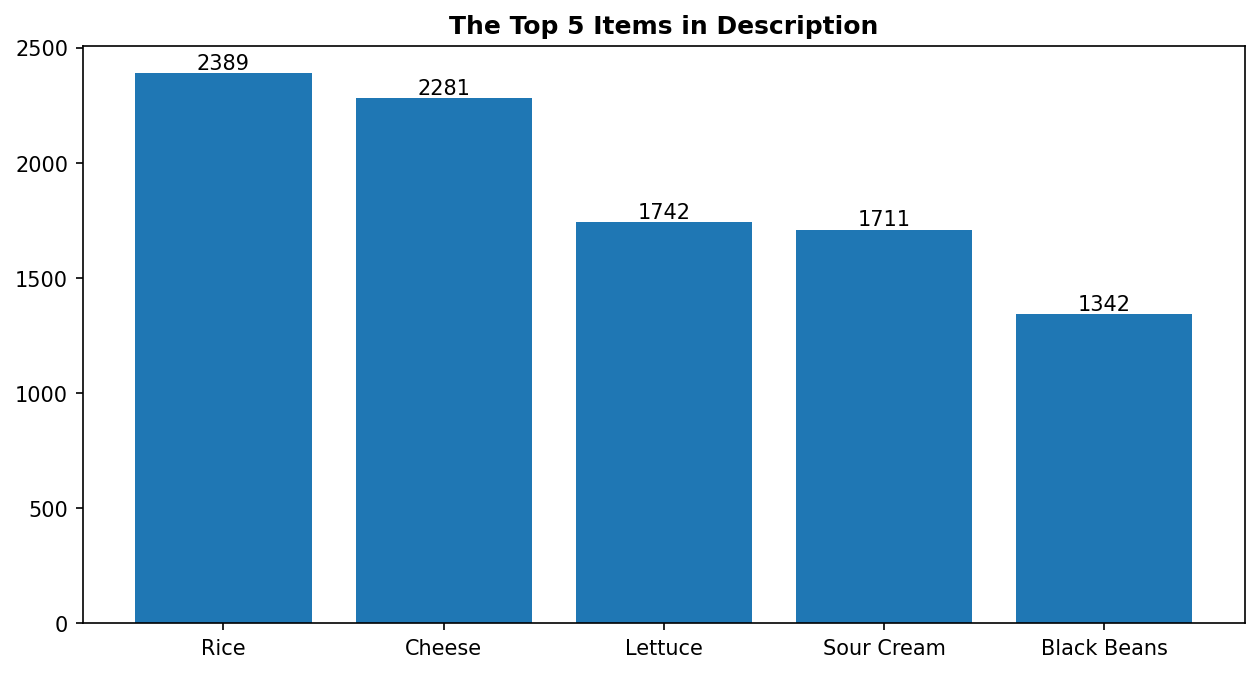

In [138]:
fig, ax = plt.subplots(figsize=(10,5), dpi=150)
bars = ax.bar(description_items.head(5).index, description_items.head(5))
ax.bar_label(bars)
plt.title('The Top 5 Items in Description', fontweight='bold')
plt.show()

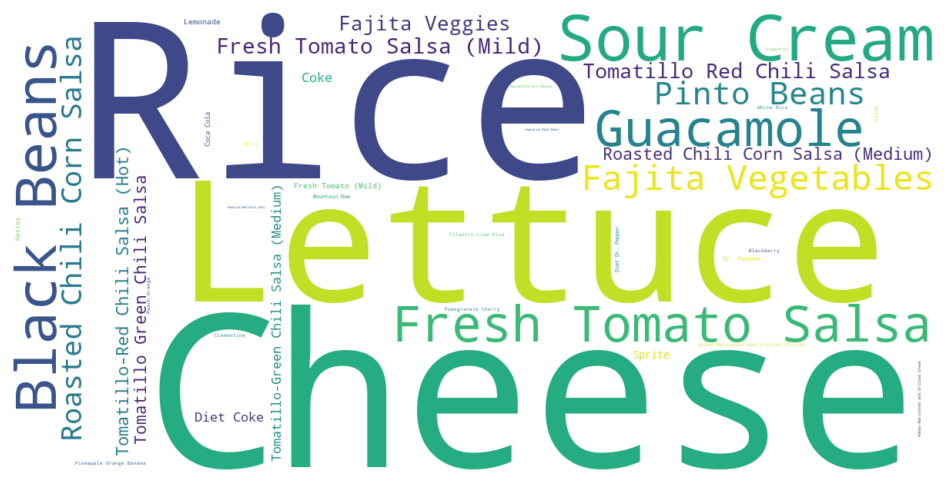

In [142]:
from wordcloud import WordCloud

# 创造字图
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(description_items)

# 用matplotlib画出字图
plt.figure(figsize=(10,5), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

我们再计算一下在配料选择非空白的订单中，各类热门配料的占比情况

In [149]:
ingredient_rate = (description_items / len(df.choice_description.dropna())).apply(lambda x: f"{x*100:.2f}%")
ingredient_rate

Rice                                    70.76%
Cheese                                  67.57%
Lettuce                                 51.60%
Sour Cream                              50.68%
Black Beans                             39.75%
Fresh Tomato Salsa                      30.98%
Guacamole                               30.72%
Fajita Vegetables                       21.39%
Pinto Beans                             17.24%
Roasted Chili Corn Salsa                13.54%
Fresh Tomato Salsa (Mild)               10.40%
Tomatillo Red Chili Salsa                9.63%
Fajita Veggies                           8.95%
Roasted Chili Corn Salsa (Medium)        8.00%
Tomatillo-Red Chili Salsa (Hot)          7.67%
Tomatillo Green Chili Salsa              6.81%
Diet Coke                                3.97%
Tomatillo-Green Chili Salsa (Medium)     3.79%
Coke                                     3.64%
Sprite                                   2.28%
Lemonade                                 0.98%
Fresh Tomato 

通过分析我们可以发现，大多数的顾客都会选择米饭，芝士，生菜，酸酱和黑豆作为配料，其中有记录的订单里，70%的顾客选择了米饭

使用ChatGPT对所有配料进行分析后，发现可选配料大致分为五类
+ 谷物和谷类食品
+ 乳制品
+ 蔬菜和豆类
+ 调味酱和沙司
+ 饮料

### 4.5 哪些商品搭配的配料比较多

In [159]:
df['choice_count'] =  df.choice_description.apply(lambda x: len(re.sub(r'[\[\]]','',x).split(',')) if isinstance(x, str) else 0)

In [164]:
df_items = df.groupby('item_name').sum().drop(['order_id','choice_description'], axis=1).sort_values(by='choice_count', ascending=False)
df_items['choices_per_item'] = df_items.choice_count / df_items.quantity
df_items.sort_values(by='choices_per_item', ascending=False)

,quantity,item_price,choice_count,choices_per_item
item_name,,,,
Veggie Salad,6,50.94,39,6.500000
Veggie Bowl,87,867.99,530,6.091954
Carnitas Salad,1,8.99,6,6.000000
Carnitas Bowl,71,736.71,417,5.873239
Veggie Burrito,97,934.77,566,5.835052
Carnitas Salad Bowl,6,66.34,35,5.833333
Burrito,6,44.40,35,5.833333
Veggie Salad Bowl,18,182.50,103,5.722222
Steak Bowl,221,2260.19,1189,5.380090


根据分析结果，Bowl, Salad, Tacos和Burrito是需要配料较多的餐品，其中肉馅沙拉、素食沙拉和素食碗所含有的配料平均在6种以上

### 4.6 平均每笔订单的价格

In [169]:
# 计算一共有多少笔订单
len(df.groupby('order_id').item_price.sum())

1834

数据集中一共有1834笔订单

In [170]:
# 总收入除以订单数，得到每笔订单的平均收入
df.item_price.sum() / 1834

18.811428571428575

每笔订单的平均价格为18.81美元

### 4.7 商品价格与配料的关系

选择所有数量为1的Chicken Bowl订单后，发现商品的价格不是一致的，最便宜为8.19$，最贵为11.25$

In [187]:
chiken_bowl_1 = df[(df['item_name'] == 'Chicken Bowl') & (df.quantity == 1)].sort_values('item_price')
chiken_bowl_1

,order_id,quantity,item_name,choice_description,item_price,choice_count
3664,1466,1,Chicken Bowl,"[Fresh Tomato (Mild), [Lettuce, Fajita Veggies...",8.19,7
2918,1160,1,Chicken Bowl,"[Fresh Tomato (Mild), [Rice, Sour Cream, Cheese]]",8.19,4
3101,1237,1,Chicken Bowl,"[Fresh Tomato (Mild), [Lettuce, Fajita Veggies...",8.19,7
934,385,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Pinto Beans, Rice...",8.49,6
937,386,1,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Rice, Fajit...",8.49,6
...,...,...,...,...,...,...
3655,1461,1,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25,7
1629,657,1,Chicken Bowl,"[Fresh Tomato Salsa, [Rice, Fajita Vegetables,...",11.25,6
2646,1051,1,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25,7
765,316,1,Chicken Bowl,"[Roasted Chili Corn Salsa, [Fajita Vegetables,...",11.25,8


首先假设**商品的单价与选择配料的数量相关**，这里使用散点图来观察两者之间的关系

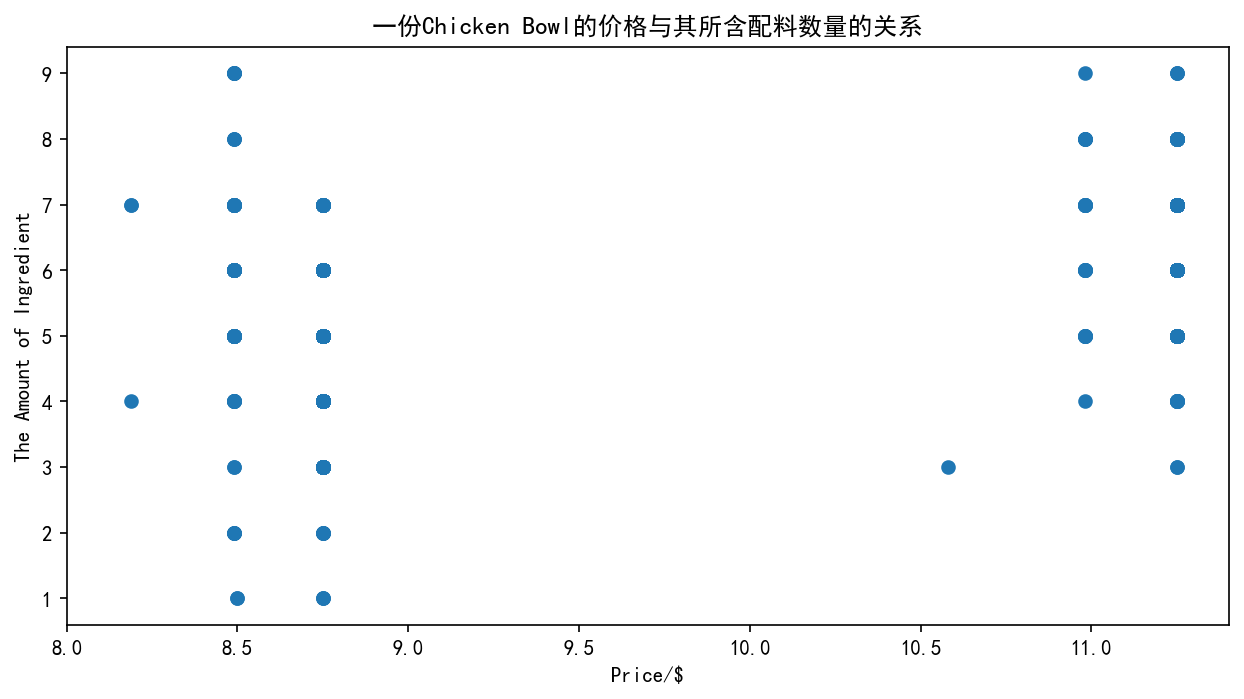

In [194]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

plt.figure(figsize=(10,5), dpi=150)
plt.scatter(chiken_bowl_1.item_price, chiken_bowl_1.choice_count)
plt.title('一份Chicken Bowl的价格与其所含配料数量的关系')
plt.xlabel("Price/$")
plt.ylabel("The Amount of Ingredient")
plt.xlim(8)
plt.show()

上图表明配料数量与商品的价格是无关的，在价格相同的情况下，订单的配料数量可能会有很大的差异。

为了检验配料与商品价格是否相关，我们检验是否存在配料相同但价格不同的情况

In [305]:
status = False
for description in chiken_bowl_1.choice_description.unique():
    temp = chiken_bowl_1[chiken_bowl_1['choice_description'] ==  description]
    if (len(temp) >= 2) & (temp.item_price.nunique() >= 2):
        print('存在配料相同但价格不同的情况')
        status = True
        break
        
if not status:
    print("不存在配料相同但价格不同的情况")

不存在配料相同但价格不同的情况


分析过后，发现配料确实影响了商品的价格，同一种商品，选择不同的配料，价格会不同